## Задача 2
Выгрузить из базы данных сотрудников, кто потратил с корпоративных банковских карт больше 20 000 рублей за 2024 год 
и имевших до совершения первой топливной транзакции (product_nm = ‘Fuel’) в 2024 году более 50 000 рублей на счету.
Требуется вывести ФИО сотрудника, кол-во транзакций списания на топливо и средний чек списания за 2024 год.

In [1]:
# Импортирование библиотек
import pandas as pd 
import matplotlib.pyplot as plt

# Загрузка данных
employees_df = pd.read_csv('./Employees_Data.csv')
products_df = pd.read_csv('./Products_Data.csv')
transactions_df = pd.read_csv('./Transactions_Data.csv')

print(employees_df.head(5))
print()
print(products_df.head(5))
print()
print(transactions_df.head(5))

  Employee_id Employee_name
0   Empl_id_1   Empl_name_1
1   Empl_id_2   Empl_name_2
2   Empl_id_3   Empl_name_3
3   Empl_id_4   Empl_name_4
4   Empl_id_5   Empl_name_5

     Product_id Product_nm
0  Product_id_1       Fuel
1  Product_id_2    Tickets
2  Product_id_3      Hotel

      Empl_id      Txn_ID    Txn_date    Txn_type    TXN_sts    Product_id  \
0   Empl_id_6  Txn_ID_810  2024-10-28     Accrual  Processed  Product_id_2   
1   Empl_id_2  Txn_ID_564  2024-07-24  Redemption  Processed  Product_id_1   
2   Empl_id_1  Txn_ID_570  2024-07-05  Redemption  Cancelled  Product_id_2   
3   Empl_id_6  Txn_ID_110  2024-03-10     Accrual  Processed  Product_id_3   
4  Empl_id_10  Txn_ID_423  2024-02-16     Accrual  Cancelled  Product_id_1   

    Amount  Balance_after_txn  
0     0.00           38301.78  
1  4169.63           32408.98  
2  2372.65           43805.13  
3     0.00           45782.93  
4     0.00           57108.96  


## Хочу найти имевших до совершения первой топливной транзакции (product_nm = ‘Fuel’) в 2024 году более 50 000 рублей на счету.

In [2]:
# оставляю транзакции только за 2024 год
transactions_df['Txn_date'] = pd.to_datetime(transactions_df['Txn_date'])
transactions_df = transactions_df[(transactions_df['Txn_date'] >= '2024-01-01') & (transactions_df['Txn_date'] <= '2024-12-31')]

# создаю колонку, в которой видно баланс до транзакции
transactions_df['Balance_before_txn'] = transactions_df['Balance_after_txn'] + transactions_df['Amount']

# создаю список первых транзакий по топливу, а также успешных и именно трат
fuel_transactions = transactions_df[(transactions_df['Product_id'] == 'Product_id_1')]
fuel_transactions = fuel_transactions[fuel_transactions['TXN_sts'] == 'Processed']
fuel_transactions = fuel_transactions[fuel_transactions['Txn_type'] == 'Redemption']
first_fuel_txn = fuel_transactions.sort_values(by=['Empl_id', 'Txn_date']).drop_duplicates('Empl_id', keep='first')
first_fuel_txn = first_fuel_txn[first_fuel_txn['Balance_before_txn'] > 50000]

# оставляю только этих сотрудников в исходной таблице
transactions_df = transactions_df[transactions_df['Empl_id'].isin(first_fuel_txn['Empl_id'])]
# оставляю только успешные транзакции
transactions_df = transactions_df[transactions_df['TXN_sts'] == 'Processed']
transactions_df = transactions_df[transactions_df['Txn_type'] == 'Redemption']


print(transactions_df.head(5))

      Empl_id      Txn_ID   Txn_date    Txn_type    TXN_sts    Product_id  \
1   Empl_id_2  Txn_ID_564 2024-07-24  Redemption  Processed  Product_id_1   
5   Empl_id_3  Txn_ID_655 2024-03-14  Redemption  Processed  Product_id_3   
27  Empl_id_8  Txn_ID_747 2024-04-23  Redemption  Processed  Product_id_1   
32  Empl_id_8  Txn_ID_333 2024-01-06  Redemption  Processed  Product_id_1   
50  Empl_id_3  Txn_ID_153 2024-05-24  Redemption  Processed  Product_id_3   

     Amount  Balance_after_txn  Balance_before_txn  
1   4169.63           32408.98            36578.61  
5   4445.67           55472.28            59917.95  
27  9967.91           38346.00            48313.91  
32  4250.66           59481.79            63732.45  
50  4691.31           55110.98            59802.29  


## Поиск сотрудников, которые потратили больше 20 000 рублей за год

In [3]:
# добавляю имена в таблицу
transactions_df = pd.merge(transactions_df, employees_df, left_on='Empl_id', right_on='Employee_id', how='left')
transactions_df = transactions_df.drop(columns=['Employee_id'])


grouped_data = transactions_df.groupby('Empl_id')['Amount'].sum().reset_index()
grouped_data = grouped_data[grouped_data['Amount'] > 20000]

print(grouped_data)

     Empl_id    Amount
1  Empl_id_2  29366.51
4  Empl_id_8  21914.12


#  ИТОГ. ФИО сотрудника, кол-во транзакций списания на топливо и средний чек списания за 2024 год. 

In [4]:
transactions_df = transactions_df[transactions_df['Empl_id'].isin(grouped_data['Empl_id'])]

final_result = transactions_df.groupby('Employee_name').agg(
    fuel_transaction_count=('Product_id', lambda x: (x == 'Product_id_1').sum()),  # количество транзакций на топливо
    avg_all_transactions=('Amount', 'mean')  # среднее по всем транзакциям
).reset_index()


print(final_result)

  Employee_name  fuel_transaction_count  avg_all_transactions
0   Empl_name_2                       3           9788.836667
1   Empl_name_8                       3           5478.530000


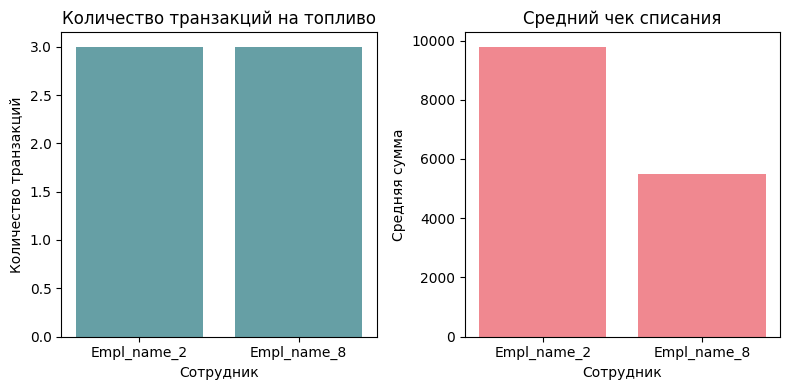

In [5]:
# создание двух графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# график для количества транзакций топлива
ax1.bar(final_result['Employee_name'], final_result['fuel_transaction_count'], color='#005f6a', alpha=0.6)
ax1.set_title('Количество транзакций на топливо')
ax1.set_xlabel('Сотрудник')
ax1.set_ylabel('Количество транзакций')

# график для среднего чека
ax2.bar(final_result['Employee_name'], final_result['avg_all_transactions'], color='#e63946', alpha=0.6)
ax2.set_title('Средний чек списания')
ax2.set_xlabel('Сотрудник')
ax2.set_ylabel('Средняя сумма')


plt.tight_layout()
plt.show()